# HW2: Training a Neural network on the mnist data

We are going to train a neural network here, like we trained a logistic regression in the class repository.

You will need to read `logistic.ipynb` and `logistic_pytorch.ipynb` in that repo for this to make any sense.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte     train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte     train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [6]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Displaying random images from the training set:


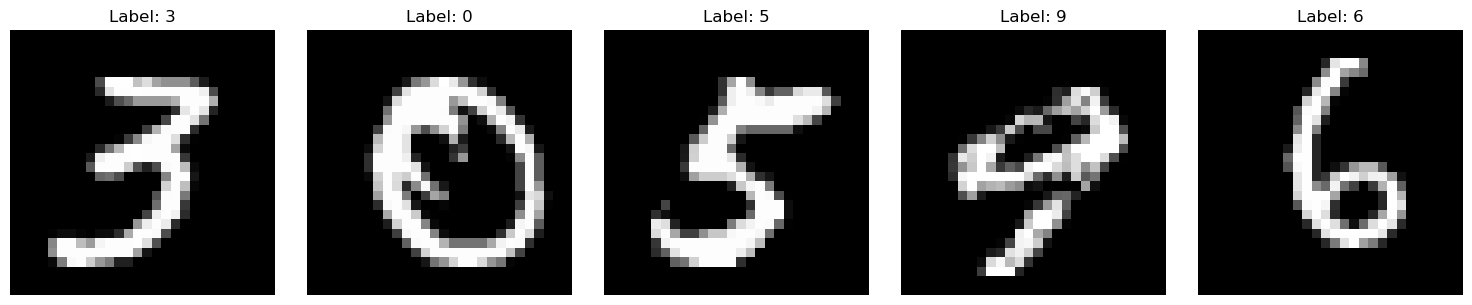

In [7]:
# Function to display random images from the dataset
def display_random_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display random images from the training set
print("Displaying random images from the training set:")
display_random_images(train_dataset)

In [33]:
# Create a full-batch loader for simple gradient descent
full_batch_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Here is our model. We do 100 linear transformations with an intercept term, on 784 inputd (all the pixels). The `x.view` flattens the 2-D pixels into a vector. Then we do the 100 linear transformations (784 slopes + 1 intercept = 785 parameters EACH!). Then we pass them through the ReLU nonlinearity (see [RELU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) for more). (otherwise everything would be a linear transform). We have 100 outputs or activations. Then we do 10 transformations to our 10 classes, at which point we apply the cross-entropy loss including a softmax.

Here is a great resource on sigmoid and softmax you should read. [https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/). Watching the 3-blue 1 brown videos again will be useful!

In [34]:
# Define the neural network model
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 100)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [35]:
# Initialize the model, loss function, and optimizer
model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [36]:
# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

`model.train()` is called at the beginning of each training epoch. This ensures that:

- If the model has dropout layers, they will be active during training.
- If the model has batch normalization layers, they will update their running statistics.

`optimizer.zero_grad()` is called at the beginning of each batch. This ensures that:

- The gradients from the previous batch don't interfere with the current batch.
- Each batch starts with a clean slate for gradient computation.


`model.eval()` is called before the evaluation phase. This ensures that:

- Dropout layers (if any) don't drop any neurons during evaluation.
- Batch normalization layers (if any) use their stored statistics instead of computing batch statistics.


`torch.no_grad()` is used during evaluation to disable gradient computation, which:

- Saves memory
- Speeds up computation
- Is appropriate since we're not updating the model during evaluation

In [37]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/20:
Train Loss: 0.3553, Train Acc: 89.97%
Val Loss: 0.3714, Val Acc: 89.38%

Epoch 2/20:
Train Loss: 0.2868, Train Acc: 91.83%
Val Loss: 0.3066, Val Acc: 91.14%

Epoch 3/20:
Train Loss: 0.2520, Train Acc: 92.93%
Val Loss: 0.2747, Val Acc: 92.14%

Epoch 4/20:
Train Loss: 0.2251, Train Acc: 93.72%
Val Loss: 0.2494, Val Acc: 92.86%

Epoch 5/20:
Train Loss: 0.2023, Train Acc: 94.33%
Val Loss: 0.2271, Val Acc: 93.58%

Epoch 6/20:
Train Loss: 0.1842, Train Acc: 94.83%
Val Loss: 0.2100, Val Acc: 93.93%

Epoch 7/20:
Train Loss: 0.1700, Train Acc: 95.28%
Val Loss: 0.1970, Val Acc: 94.28%

Epoch 8/20:
Train Loss: 0.1601, Train Acc: 95.44%
Val Loss: 0.1886, Val Acc: 94.42%

Epoch 9/20:
Train Loss: 0.1459, Train Acc: 95.97%
Val Loss: 0.1751, Val Acc: 94.98%

Epoch 10/20:
Train Loss: 0.1362, Train Acc: 96.22%
Val Loss: 0.1673, Val Acc: 95.18%

Epoch 11/20:
Train Loss: 0.1287, Train Acc: 96.39%
Val Loss: 0.1596, Val Acc: 95.34%

Epoch 12/20:
Train Loss: 0.1207, Train Acc: 96.69%
Val Loss: 0.

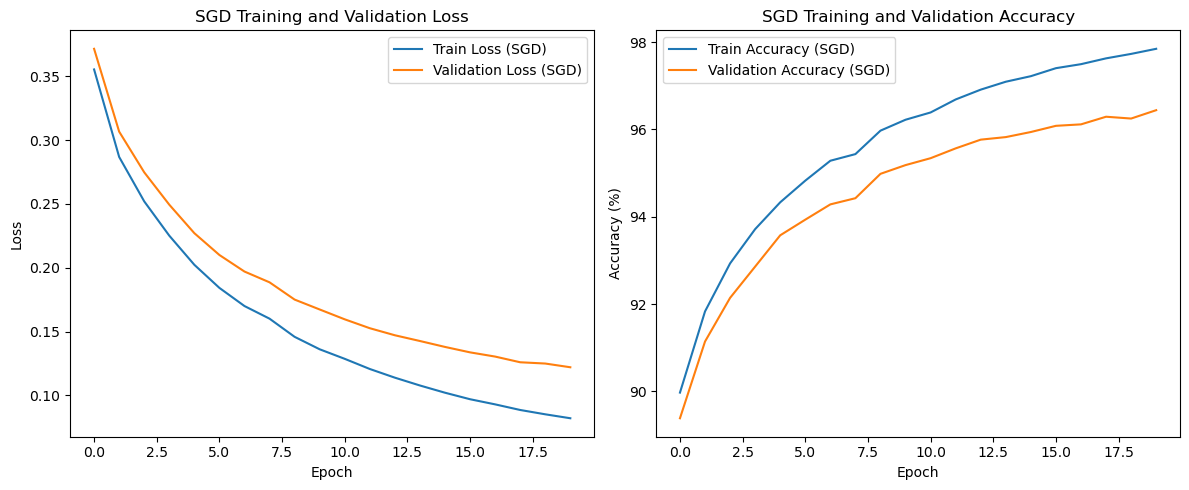

Test Loss: 2.3353, Test Acc: 9.90%
SGD Test Loss: 0.1045, SGD Test Acc: 96.91%


In [38]:
model_sgd = MultiLayerPerceptron()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

num_epochs_sgd = 20
train_losses_sgd, train_accuracies_sgd = [], []
val_losses_sgd, val_accuracies_sgd = [], []

for epoch in range(num_epochs_sgd):
    model.train()
    for images, labels in train_loader:
        optimizer_sgd.zero_grad()
        outputs = model_sgd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
    
    train_loss, train_acc = validate(model_sgd, train_loader, criterion)
    val_loss, val_acc = validate(model_sgd, val_loader, criterion)
    
    train_losses_sgd.append(train_loss)
    train_accuracies_sgd.append(train_acc)
    val_losses_sgd.append(val_loss)
    val_accuracies_sgd.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs_sgd}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

# Plot SGD training and validation losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss (SGD)')
plt.plot(val_losses_sgd, label='Validation Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('SGD Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_sgd, label='Train Accuracy (SGD)')
plt.plot(val_accuracies_sgd, label='Validation Accuracy (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SGD Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Evaluate the SGD model on the test set
test_loss_sgd, test_acc_sgd = validate(model_sgd, test_loader, criterion)
print(f"SGD Test Loss: {test_loss_sgd:.4f}, SGD Test Acc: {test_acc_sgd:.2f}%")

### Q1. How do the accuracy and losses compare to the logistic regression case in the repository from class? How many parameters does this model have. 

For example, a `Linear(28*28, 100)` layer has 784 inputs and 100 outputs, so 784 slopes and an intercept per output, or 785 parameters per output. So for 100 outputs/activations, we have 78500 parameters!

*your answer here*

### Q2. The training loss is lower than the validation set loss, and the training accuracy higher. Is this a good or bad thing?

A validation set is an independent dataset where you test your model.

### Why do you think your validation accuracy is lower?

*your answer here*

### Q3. Add one more intermediate linear and Relu layer pair and see what accuracy you get. How many parameters does this new model have?

To be precise, this is 28x28 inputs to a 100 neuron layer. Then a Relu. Then a 100 neuron to 100 neuron layer. Then a relu. Then a 100 to 10 classes.

In [39]:
# your code here

*your answer here*